In [1]:
from pcit import MetaEstimator, StructureEstimation, IndependenceTest
from sklearn.datasets import load_boston, load_iris
import numpy as np

In [2]:
X = load_boston()['data']
y = np.reshape(load_boston()['target'],(-1,1))
boston = np.concatenate((X,y),axis = 1)
boston_names = ['crime', 'land_zoned', '%industry', 'riverdummy', 'nitricox', 'rooms/dwelling', 'age', 
                 'distemploycent', 'accesshighway', 'proptaxrate','pupiltecherratio','%black','lowerstatpop','medvhome']

# Controlling for socioeconomic factors in the boston data set,  is there a relationship between industrialization and crime in a neighborhood?

In [15]:
p = len(boston_names)

# Industrialization
X = boston[:,[i for i in range(p) if boston_names[i] in ['land_zoned', '%industry', 'nitricox']]]

# Crime
Y = boston[:,[i for i in range(p) if boston_names[i] in ['crime']]]

# Socioeconomic factors
Z = boston[:,[i for i in range(p) 
                  if boston_names[i] in ['age', 'pupilteacherratio', '%black', 'lowerstatpop', 'medvhome']]]

p_values_adj, independent, conf_int_out = IndependenceTest.PCIT(X, Y, z = Z)

In [16]:
print(p_values_adj)

[  1.86244841e-02   2.36008035e-08   3.10163361e-06]


### It seems that neither 'land_zoned', '%industry' and 'nitricox' are conditionally independent from crime, and hence..

In [17]:
print(independent)

(False, 4.2639338252553015e-19)


### .. the two data sets are not independent
###  

# In the Iris dataset, given the petal information of flowers, are the sepal measures independent of the class

In [89]:
X = load_iris()['data']
y = np.reshape(load_iris()['target'],(-1,1))
iris = np.concatenate((X,y),axis = 1)
iris_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'class']

In [90]:
X = iris[:,0:2]
print('X contains ', iris_names[0:2])

Y = iris[:,4:5]
print('Y contains ', iris_names[4:5])

Z = iris[:,2:4]
print('Z contains ', iris_names[2:4])

X contains  ['sepal length (cm)', 'sepal width (cm)']
Y contains  ['class']
Z contains  ['petal length (cm)', 'petal width (cm)']


### Define custom set of estimators, one list for regression task, one for classification task, and store in tuple

In [99]:
from sklearn.linear_model import RidgeCV, LassoCV, SGDClassifier, LogisticRegression
                    
regressors = [RidgeCV(), LassoCV()]
classifiers = [SGDClassifier(loss = 'log', random_state = 0), LogisticRegression()]

estimators = (regressors, classifiers)

custom_estim = MetaEstimator.MetaEstimator(
                estimators = estimators,
                                method = 'multiplexing')

### Use 'custom_estim', an object of the MetaEstimator class, in the PCIT

In [100]:
p_values_adj, independent, conf_int_out = IndependenceTest.PCIT(X, Y, z = Z, estimator = custom_estim)
print(independent)

(False, 9.6837307468477695e-08)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


### It seems that there is some information that is shared exclusively between class and petal measures
###   

# Learn an undirected graph for the Boston Housing data set
### The skeleton is learnt in one command, using default settings

In [134]:
p_val, skel = StructureEstimation.find_neighbours(boston)
print(skel)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 1 0 1 0 0 0 0]
 [0 1 1 1 1 0 0 0 1 0 1 0 0 0]
 [0 1 1 1 0 0 1 0 0 0 1 1 1 1]
 [0 1 1 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 1 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 1 1 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 1 0 1 0 0 0 0 0 0 1 1]]


### To visualize the graph, one can use the packages networkx and matplotlib

In [136]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(skeleton, feature_names = None, title_graph = None):
    '''Draw graphs from skeletons'''
    G = nx.from_numpy_matrix(skeleton)
    if feature_names is not None:
        labels = {}
        for i in range(len(feature_names)):
            labels.update({i: feature_names[i]})
        nx.relabel_nodes(G, labels, copy=False)

    graph_pos = nx.circular_layout(G)
    graph_labels = [x for x in graph_pos]
    graph_pos_up = dict()
    for i in range(len(graph_labels)):
        new_position = graph_pos[graph_labels[i]] + np.array((0,0.05))
        graph_pos_up[graph_labels[i]] = new_position

    nx.draw_networkx_nodes(G, graph_pos, node_size=1000, node_color='blue', alpha=0.2)
    nx.draw_networkx_edges(G, graph_pos, alpha=0.5, font_color = 'blue', style = 'dotted', width = 2)
    nx.draw_networkx_labels(G, graph_pos_up, font_size=10, font_family='sans-serif')
    plt.title(title_graph)

    plt.show()

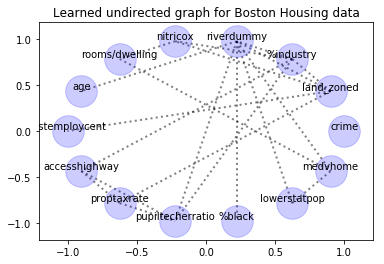

In [137]:
draw_graph(skel, feature_names = boston_names, title_graph = 'Learned undirected graph for Boston Housing data')